### Import Dataset

In [35]:
import io
import pandas as pd
import matplotlib.pyplot as pt
import numpy as np
data = pd.read_csv("Twitter_Data.csv")

### View Dataset

In [36]:
data.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [37]:
data.shape

(162980, 2)

### Data Preprocessing

In [38]:
data.category.unique()

array([-1.,  0.,  1., nan])

In [39]:
# To check Number of nan values in each column
data.isna().sum()

clean_text    4
category      7
dtype: int64

In [40]:
data[data['category'].isna()]

,clean_text,category
130448,the foundation stone northeast gas grid inaugu...,NaN
155642,dear terrorists you can run but you cant hide ...,NaN
155698,offense the best defence with mission shakti m...,NaN
155770,have always heard politicians backing out thei...,NaN
158693,modi government plans felicitate the faceless ...,NaN
159442,chidambaram gives praises modinomics,NaN
160559,the reason why modi contested from seats 2014 ...,NaN


In [41]:
data[data['clean_text'].isna()]

,clean_text,category
148,NaN,0.0
158694,NaN,-1.0
159443,NaN,0.0
160560,NaN,1.0


In [42]:
data.drop(data[data['clean_text'].isna()].index, inplace=True)
data.drop(data[data['category'].isna()].index, inplace=True)
data.isna().sum()

clean_text    0
category      0
dtype: int64

In [43]:
# Inserting a column name sentiment in our dataset
sentiment_map={-1:2,1:1,0:0}
data.insert(2,'sentiment',[sentiment_map[s] for s in data.category],True)
data.head()

,clean_text,category,sentiment
0,when modi promised “minimum government maximum...,-1.0,2
1,talk all the nonsense and continue all the dra...,0.0,0
2,what did just say vote for modi welcome bjp t...,1.0,1
3,asking his supporters prefix chowkidar their n...,1.0,1
4,answer who among these the most powerful world...,1.0,1


In [44]:
#labeling
reviews = np.array(data['clean_text'])[:]
labels = np.array(data['sentiment'])[:]
reviews

array(['when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples',
       'talk all the nonsense and continue all the drama will vote for modi ',
       'what did just say vote for modi  welcome bjp told you rahul the main campaigner for modi think modi should just relax',
       ..., 'did you cover her interaction forum where she left ',
       'there big project came into india modi dream project but not happened reality',
       'have you ever listen about like gurukul where discipline are maintained even narendra modi rss only maintaining the culture indian more attack politics but someone attack hinduism rss will take action that proud for '],
      dtype=object)

In [45]:
labels

array([2, 0, 1, ..., 0, 0, 1])

In [46]:
# counting each labels
from collections import Counter

Counter(labels)

Counter({1: 72249, 0: 55211, 2: 35509})

#### remove all the special characters(@,#,$ etc), punctuations and URL from all the esteemed tweets.

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
import csv


def preProcessor(Tweet):
    import re
    from string import punctuation
    text=re.sub(r'(http|ftp|https):\/\/([\w\-_]+(?:(?:\.[\w\-_]+)+))([\w\-\.,@?^=%&:/~\+#]*[\w\-\@?^=%&/~\+#])?', ' ', Tweet)
    text=re.sub(r'['+punctuation+']',' ',Tweet)
    text=re.sub(r'#(\w+)',' ',Tweet)
    text=re.sub(r'@(\w+)',' ',Tweet)
    #print(token.tokenize(text))
    return Tweet

In [48]:
Tweet="yash#123rathod abc"
import re
text=re.sub(r'#(\w+)',' ',Tweet)
text

'yash  abc'

##### Given the token id's to each of the words in the tweet. Then we vectorize all the tokens.

In [49]:
token=RegexpTokenizer(r'\w+')
cv=CountVectorizer(lowercase=True,preprocessor=preProcessor,stop_words='english',ngram_range=(1,1),tokenizer=token.tokenize)
text_counts=cv.fit_transform(data['clean_text'].values.astype('U'))

/Users/apple/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


#### Train Test Split

In [50]:
from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(text_counts,data['sentiment'],test_size=0.3)
x_train, x_test, y_train, y_test = train_test_split(text_counts,data['sentiment'],test_size=0.3)

In [51]:
print((x_train.shape,y_train.shape))

((114078, 106644), (114078,))


In [52]:
print((x_test.shape,y_test.shape))


((48891, 106644), (48891,))


#### Building the Model

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow import keras

In [54]:
coo = x_train.tocoo()
indices = np.mat([coo.row, coo.col]).transpose()
x_train_tensor = tf.SparseTensor(indices, coo.data, coo.shape)

In [55]:
x_train_tensor = tf.sparse.reorder(x_train_tensor)
x_train_tensor.shape

TensorShape([114078, 106644])

In [56]:
coo = x_test.tocoo()
indices = np.mat([coo.row, coo.col]).transpose()
x_test_tensor = tf.SparseTensor(indices, coo.data, coo.shape)
x_test_tensor = tf.sparse.reorder(x_test_tensor)

In [57]:
y_train=tf.convert_to_tensor(y_train)
y_test=tf.convert_to_tensor(y_test)


In [58]:
y_train=tf.keras.utils.to_categorical(y_train)
print(y_train.shape)

(114078, 3)


In [59]:
y_test=tf.keras.utils.to_categorical(y_test)
y_test.shape

(48891, 3)

In [60]:
# Input - Layer
model=Sequential()
model.add(keras.layers.Dense(50, activation = "relu", input_dim=x_train_tensor.shape[1]))
# Hidden - Layers
model.add(keras.layers.Dropout(0.3, noise_shape=None, seed=None))
model.add(keras.layers.Dense(50, activation = "relu"))
model.add(keras.layers.Dropout(0.2, noise_shape=None, seed=None))
model.add(keras.layers.Dense(50, activation = "relu"))
# Output- Layer
model.add(keras.layers.Dense(3, activation = "softmax"))
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 50)                5332250   
                                                                 
 dropout_32 (Dropout)        (None, 50)                0         
                                                                 
 dense_65 (Dense)            (None, 50)                2550      
                                                                 
 dropout_33 (Dropout)        (None, 50)                0         
                                                                 
 dense_66 (Dense)            (None, 50)                2550      
                                                                 
 dense_67 (Dense)            (None, 3)                 153       
                                                                 
Total params: 5337503 (20.36 MB)
Trainable params: 53

In [61]:
batch_sizes_fraction = [0.002,0.005,0.1,0.5,1]

In [80]:
accuracy=[]
for i in batch_sizes_fraction:
    # Input - Layer
    model=Sequential()
    model.add(keras.layers.Dense(50, activation = "relu", input_dim=x_train_tensor.shape[1]))
    # Hidden - Layers
    model.add(keras.layers.Dropout(0.3, noise_shape=None, seed=None))
    model.add(keras.layers.Dense(50, activation = "relu"))
    model.add(keras.layers.Dropout(0.3, noise_shape=None, seed=None))
    model.add(keras.layers.Dense(50, activation = "relu"))
    # Output- Layer
    model.add(keras.layers.Dense(3, activation = "softmax"))
    model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
    )   
    history=model.fit(x_train_tensor,y_train,epochs=10,batch_size=int(i*x_train_tensor.shape[0]),validation_data=(x_test_tensor, y_test),verbose=False)
    print(str(i) + " : " + str(model.evaluate(x_test_tensor,y_test)))
    accuracy.append(history)

    

1528/1528 [==============================] - 1s 489us/step - loss: 0.7107 - accuracy: 0.8383


0.002 : [0.7107016444206238, 0.8383342623710632]
1528/1528 [==============================] - 1s 456us/step - loss: 0.7529 - accuracy: 0.8413


0.005 : [0.7529133558273315, 0.8412795662879944]
1528/1528 [==============================] - 1s 444us/step - loss: 0.4842 - accuracy: 0.8470
0.1 : [0.4842064678668976, 0.847006618976593]


1528/1528 [==============================] - 1s 452us/step - loss: 0.9686 - accuracy: 0.4703
0.5 : [0.9685653448104858, 0.4702501595020294]


1528/1528 [==============================] - 1s 449us/step - loss: 1.0179 - accuracy: 0.4427
1 : [1.0179084539413452, 0.4426786005496979]


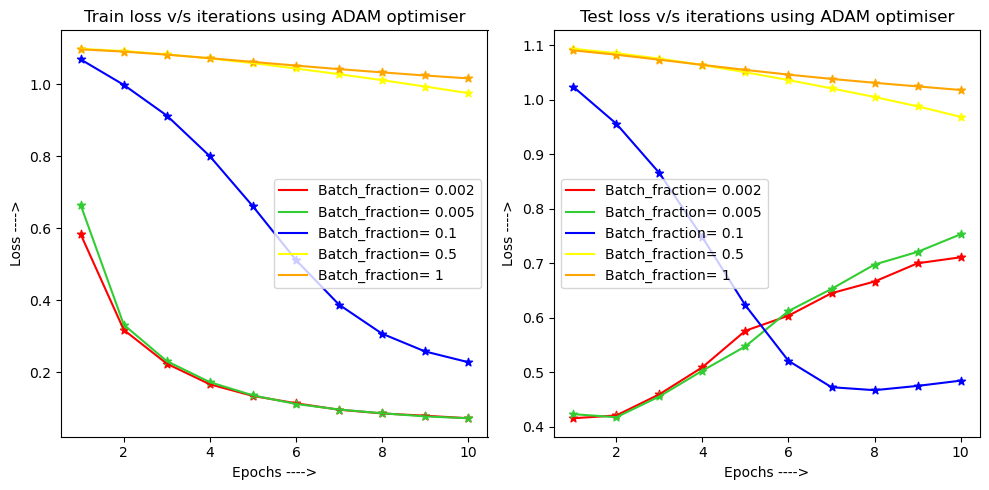

In [81]:
color_array=['red','limegreen','blue','yellow','orange','green']
fig,ax = pt.subplots(1,2,figsize=(10,5))
for i in range(len(batch_sizes_fraction)): 
    ax[0].plot([_ for _ in range(1,11)],accuracy[i].history['loss'],color=color_array[i],label=f"Batch_fraction= {batch_sizes_fraction[i]}")
    ax[0].scatter([_ for _ in range(1,11)],accuracy[i].history['loss'],color=color_array[i],marker="*")
    ax[1].plot([_ for _ in range(1,11)],accuracy[i].history['val_loss'],color=color_array[i],label=f"Batch_fraction= {batch_sizes_fraction[i]}")
    ax[1].scatter([_ for _ in range(1,11)],accuracy[i].history['val_loss'],color=color_array[i],marker="*")


ax[0].set_xlabel("Epochs ---->")
ax[0].set_ylabel("Loss ---->")
ax[0].set_title("Train loss v/s iterations using ADAM optimiser")
ax[1].set_xlabel("Epochs ---->")
ax[1].set_ylabel("Loss ---->")
ax[1].set_title("Test loss v/s iterations using ADAM optimiser")
ax[0].legend()
ax[1].legend()
pt.tight_layout()

In [82]:
accuracy=[]
for i in batch_sizes_fraction:
    # Input - Layer
    model=Sequential()
    model.add(keras.layers.Dense(50, activation = "relu", input_dim=x_train_tensor.shape[1]))
    # Hidden - Layers
    model.add(keras.layers.Dropout(0.3, noise_shape=None, seed=None))
    model.add(keras.layers.Dense(50, activation = "relu"))
    model.add(keras.layers.Dropout(0.2, noise_shape=None, seed=None))
    model.add(keras.layers.Dense(50, activation = "relu"))
    # Output- Layer
    model.add(keras.layers.Dense(3, activation = "softmax"))
    model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.SGD(),
    metrics=["accuracy"],
    )   
    history=model.fit(x_train_tensor,y_train,epochs=10,batch_size=int(i*x_train_tensor.shape[0]),validation_data=(x_test_tensor, y_test),verbose=False)
    print(str(i) + " : " + str(model.evaluate(x_test_tensor,y_test)))
    accuracy.append(history)

1528/1528 [==============================] - 1s 480us/step - loss: 0.4855 - accuracy: 0.8274
0.002 : [0.4854733943939209, 0.8273915648460388]


1528/1528 [==============================] - 1s 445us/step - loss: 0.8584 - accuracy: 0.6356
0.005 : [0.8584292531013489, 0.6356384754180908]


1528/1528 [==============================] - 1s 439us/step - loss: 1.0709 - accuracy: 0.4425
0.1 : [1.070927381515503, 0.44251498579978943]


1528/1528 [==============================] - 1s 445us/step - loss: 1.0903 - accuracy: 0.4424
0.5 : [1.0903162956237793, 0.44241270422935486]


1528/1528 [==============================] - 1s 433us/step - loss: 1.0944 - accuracy: 0.3925
1 : [1.0944312810897827, 0.392546683549881]


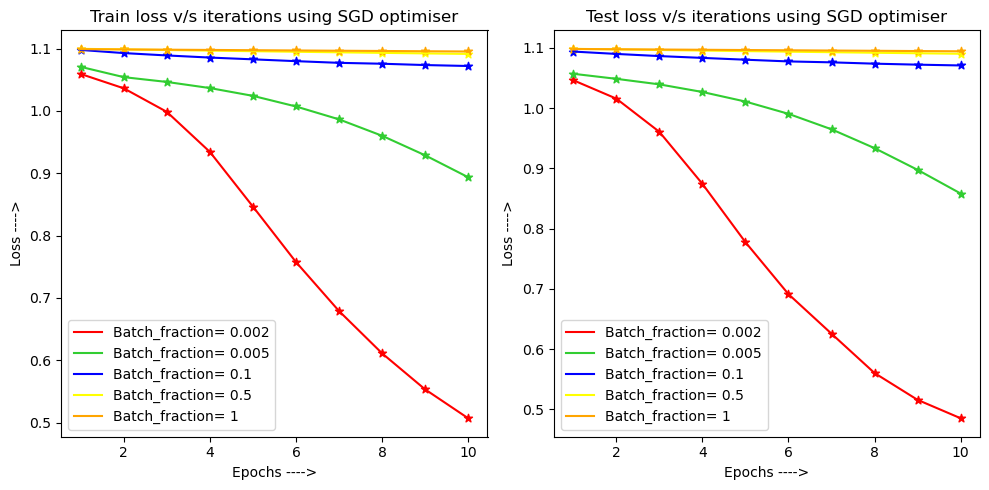

In [83]:
color_array=['red','limegreen','blue','yellow','orange','green']
fig,ax = pt.subplots(1,2,figsize=(10,5))
for i in range(len(batch_sizes_fraction)): 
    ax[0].plot([_ for _ in range(1,11)],accuracy[i].history['loss'],color=color_array[i],label=f"Batch_fraction= {batch_sizes_fraction[i]}")
    ax[0].scatter([_ for _ in range(1,11)],accuracy[i].history['loss'],color=color_array[i],marker="*")
    ax[1].plot([_ for _ in range(1,11)],accuracy[i].history['val_loss'],color=color_array[i],label=f"Batch_fraction= {batch_sizes_fraction[i]}")
    ax[1].scatter([_ for _ in range(1,11)],accuracy[i].history['val_loss'],color=color_array[i],marker="*")


ax[0].set_xlabel("Epochs ---->")
ax[0].set_ylabel("Loss ---->")
ax[0].set_title("Train loss v/s iterations using SGD optimiser")
ax[1].set_xlabel("Epochs ---->")
ax[1].set_ylabel("Loss ---->")
ax[1].set_title("Test loss v/s iterations using SGD optimiser")
ax[0].legend()
ax[1].legend()
pt.tight_layout()

In [84]:
accuracy=[]
for i in batch_sizes_fraction:
    # Input - Layer
    model=Sequential()
    model.add(keras.layers.Dense(50, activation = "relu", input_dim=x_train_tensor.shape[1]))
    # Hidden - Layers
    model.add(keras.layers.Dropout(0.3, noise_shape=None, seed=None))
    model.add(keras.layers.Dense(50, activation = "relu"))
    model.add(keras.layers.Dropout(0.2, noise_shape=None, seed=None))
    model.add(keras.layers.Dense(50, activation = "relu"))
    # Output- Layer
    model.add(keras.layers.Dense(3, activation = "softmax"))
    model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
    )   
    history=model.fit(x_train_tensor,y_train,epochs=10,batch_size=int(i*x_train_tensor.shape[0]),validation_data=(x_test_tensor, y_test),verbose=False)
    print(str(i) + " : " + str(model.evaluate(x_test_tensor,y_test)))
    accuracy.append(history)

1528/1528 [==============================] - 1s 533us/step - loss: 0.4652 - accuracy: 0.8583
0.002 : [0.4652050733566284, 0.858317494392395]


1528/1528 [==============================] - 1s 428us/step - loss: 0.5514 - accuracy: 0.8623


0.005 : [0.5513582825660706, 0.8622854948043823]
1528/1528 [==============================] - 1s 436us/step - loss: 0.4322 - accuracy: 0.8543


0.1 : [0.4322197735309601, 0.8543494939804077]
1528/1528 [==============================] - 1s 455us/step - loss: 0.9238 - accuracy: 0.4519


0.5 : [0.9237671494483948, 0.451923668384552]
1528/1528 [==============================] - 1s 526us/step - loss: 1.0572 - accuracy: 0.4437
1 : [1.0571566820144653, 0.4436603784561157]


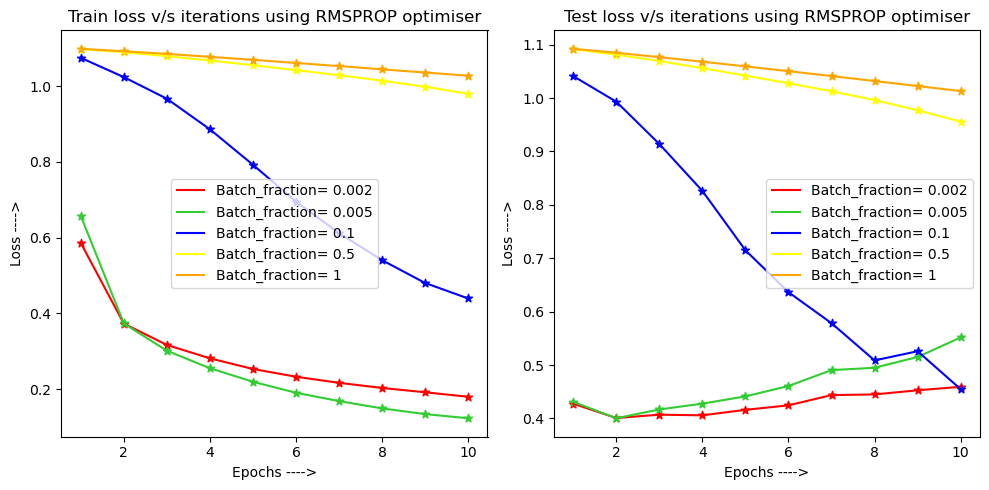

In [70]:
color_array=['red','limegreen','blue','yellow','orange','green']
fig,ax = pt.subplots(1,2,figsize=(10,5))
for i in range(len(batch_sizes_fraction)): 
    ax[0].plot([_ for _ in range(1,11)],accuracy[i].history['loss'],color=color_array[i],label=f"Batch_fraction= {batch_sizes_fraction[i]}")
    ax[0].scatter([_ for _ in range(1,11)],accuracy[i].history['loss'],color=color_array[i],marker="*")
    ax[1].plot([_ for _ in range(1,11)],accuracy[i].history['val_loss'],color=color_array[i],label=f"Batch_fraction= {batch_sizes_fraction[i]}")
    ax[1].scatter([_ for _ in range(1,11)],accuracy[i].history['val_loss'],color=color_array[i],marker="*")


ax[0].set_xlabel("Epochs ---->")
ax[0].set_ylabel("Loss ---->")
ax[0].set_title("Train loss v/s iterations using RMSPROP optimiser")
ax[1].set_xlabel("Epochs ---->")
ax[1].set_ylabel("Loss ---->")
ax[1].set_title("Test loss v/s iterations using RMSPROP optimiser")
ax[0].legend()
ax[1].legend()
pt.tight_layout()

##### Training loss decreases in all three model(using ADAM/SGD/RMSPROP)
 
##### The best accuracy we achieved by using RMSPROP (around 86%) followed by ADAM(around 84%) and worst accuracy we get in case of SGD (as expected)

##### Also SGD perform worst in terms of convergence also, on the other hand we can say that ADAM and RMSPROP are quite similar in terms of convergence but ADAM is better than RMSPROP in this case in terms of convergence

##### we can see that in SGD accuracy will decrease as we increase the batch size on the other hand in ADAM and RMSPROP it will first increase and then decrease

##### In all three cases loss will increase as we increases the batch size (The higher the batch size the lower the variance)